# 不同表达分析

大量RNA-seq分析的一个重要任务是不同的表达，我们可以用omicverse来执行。对于不同的表达分析，我们先将`gene_id`改为基质的`gene_name`。当我们的数据集存在批效应时，我们可以使用`DEseq2`的`SizeFactors`对其进行归一化，并使用wilcoxon的t检验计算基因的p值。这里我们用一个来自`featurements`的矩阵来演示这个管道。同样的流水线通常用于分析任何`RNA-seq`任务集合。


In [1]:
import omicverse as ov
import scanpy as sc
import matplotlib.pyplot as plt

ov.plot_set()

/slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "



   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.5, Tutorials: https://omicverse.readthedocs.io/
All dependencies are satisfied.


## Geneset下载
当我们需要转换一个`gene_id`时，我们需要准备一个映射对文件。我们对6个基因组gtf文件进行了预处理，生成了`T2T-CHM13`、`GRCh38`、`GRCh37`、`GRCm39`、`danRer7`、`danRer11`等图谱对。如果需要转换其他id映射，可以使用gtf生成自己的映射，将文件放在`genesets`目录中。

In [2]:
ov.utils.download_geneid_annotation_pair()

......Geneid Annotation Pair download start: pair_GRCm39
......Downloading dataset save to genesets/pair_GRCm39.tsv
......Creating directory genesets
......[pair_GRCm39 Size of file]: 0.14 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！3.5966837406158447.2f s
......Geneid Annotation Pair download start: pair_T2TCHM13
......Downloading dataset save to genesets/pair_T2TCHM13.tsv
......[pair_T2TCHM13 Size of file]: 0.15 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！32.660491704940796.2f s
......Geneid Annotation Pair download start: pair_GRCh38
......Downloading dataset save to genesets/pair_GRCh38.tsv
......[pair_GRCh38 Size of file]: 0.13 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！20.518221855163574.2f s
......Geneid Annotation Pair download start: pair_GRCh37
......Downloading dataset save to genesets/pair_GRCh37.tsv
......[pair_GRCh37 Siz

请注意，此数据集未经过任何处理，仅由`featurets`导出，序列比对是从`CRCm39`的基因组文件执行的
样例数据可从:
https://raw.githubusercontent.com/Starlitnightly/omicverse/master/sample/counts.txt

In [2]:
data = ov.read("../../data/counts.txt", index_col=0, header=1)
#replace the columns `.bam` to `` 
data.columns=[i.split('/')[-1].replace('.bam','') for i in data.columns]
data.head()

,1--1,1--2,2--1,2--2,3--1,3--2,4--1,4--2,4-3,4-4,Blank-1,Blank-2
Geneid,,,,,,,,,,,,
ENSMUSG00000102628,0,0,0,0,5,0,0,0,0,0,0,9
ENSMUSG00000100595,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000097426,5,0,0,0,0,0,0,1,0,0,0,0
ENSMUSG00000104478,0,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104385,0,0,0,0,0,0,0,0,0,0,0,0


## ID mapping

我们使用之前下载的作图对文件`GRCm39`进行`gene_id`作图

In [4]:
data=ov.bulk.Matrix_ID_mapping(data,'../../data/genesets/pair_GRCm39.tsv')
data.head()

,1--1,1--2,2--1,2--2,3--1,3--2,4--1,4--2,4-3,4-4,Blank-1,Blank-2
1700001C19Rik,14,0,0,9,10,24,18,9,0,9,0,12
Cdc14b,179,174,240,448,185,184,173,119,327,279,163,449
Gm23293,0,0,0,1,0,0,0,0,0,0,0,0
Gm50065,0,0,0,0,0,0,0,0,0,0,0,0
Gm52994,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
import pandas as pd
def Matrix_ID_mapping(data:pd.DataFrame,gene_ref_path:str)->pd.DataFrame:
    """
    Maps gene IDs in the input data to gene symbols using a reference table.

    Arguments:
        data: The input data containing gene IDs as index.
        gene_ref_path: The path to the reference table containing the mapping from gene IDs to gene symbols.

    Returns:
        data: The input data with gene IDs mapped to gene symbols.

    """
    
    pair=pd.read_csv(gene_ref_path,sep='\t',index_col=0)
    ret_gene=list(set(data.index.tolist()) & set(pair.index.tolist()))
    print(pair.index.tolist())
    data=data.loc[ret_gene]
    #data=data_drop_duplicates_index(data)
    new_index=[]
    for i in ret_gene:
        a=pair.loc[i,'symbol']
        if str(a)=='nan':
            new_index.append(i)
        else:
            new_index.append(a)
    data.index=new_index
    return data

# Matrix_ID_mapping(data,'../../data/genesets/pair_GRCm39.tsv')

['ENSMUSG00000102628', 'ENSMUSG00000100595', 'ENSMUSG00000097426', 'ENSMUSG00000104478', 'ENSMUSG00000104385', 'ENSMUSG00000086053', 'ENSMUSG00000101231', 'ENSMUSG00000102135', 'ENSMUSG00000103282', 'ENSMUSG00000101097', 'ENSMUSG00000100764', 'ENSMUSG00000102095', 'ENSMUSG00000102534', 'ENSMUSG00000100831', 'ENSMUSG00000100884', 'ENSMUSG00000100635', 'ENSMUSG00000102213', 'ENSMUSG00000100480', 'ENSMUSG00000089037', 'ENSMUSG00000103629', 'ENSMUSG00002076531', 'ENSMUSG00000100025', 'ENSMUSG00000051285', 'ENSMUSG00000098201', 'ENSMUSG00000103509', 'ENSMUSG00000048538', 'ENSMUSG00000103709', 'ENSMUSG00000077244', 'ENSMUSG00000102768', 'ENSMUSG00000097797', 'ENSMUSG00000103498', 'ENSMUSG00000103067', 'ENSMUSG00000102320', 'ENSMUSG00000104226', 'ENSMUSG00000103903', 'ENSMUSG00000103557', 'ENSMUSG00000026312', 'ENSMUSG00000100290', 'ENSMUSG00000100758', 'ENSMUSG00000099926', 'ENSMUSG00000039748', 'ENSMUSG00000118715', 'ENSMUSG00000104158', 'ENSMUSG00000103540', 'ENSMUSG00000057363', 'ENSMUSG0

,1--1,1--2,2--1,2--2,3--1,3--2,4--1,4--2,4-3,4-4,Blank-1,Blank-2
1700001C19Rik,14,0,0,9,10,24,18,9,0,9,0,12
Cdc14b,179,174,240,448,185,184,173,119,327,279,163,449
Gm23293,0,0,0,1,0,0,0,0,0,0,0,0
Gm50065,0,0,0,0,0,0,0,0,0,0,0,0
Gm52994,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
Olfr150,0,0,0,0,0,0,0,0,0,0,0,0
Klrb1b,18,41,95,40,34,34,37,48,64,125,1,64
Rnf223,99,41,129,128,52,128,228,83,64,73,54,168
Clec3a,0,0,0,0,0,0,0,0,0,0,0,0


## 用ov进行不同表达分析
我们可以通过ov，简单地做微分表达式分析，简单地提供一个表达式矩阵。要运行DEG，我们只需要
- 通过featucount或任何其他限定方法读取原始计数。
- 创建一个ov DEseq对象。

In [5]:
dds = ov.bulk.pyDEG(data)
dds

我们注意到之前的基因名称映射存在一些重复，我们将处理重复索引，只保留表达最高的基因

In [6]:
dds.drop_duplicates_index()
print('... drop_duplicates_index success')

... drop_duplicates_index success


我们还需要删除表达式矩阵的批处理效果，DEseq2的estimateSizeFactors将用于规范化我们的矩阵

In [10]:
dds.normalize()
print('... estimateSizeFactors and normalize success')

... estimateSizeFactors and normalize success


现在我们可以从基质中计算出不同的表达基因，我们需要输入实验组和对照组

In [7]:
treatment_groups=['4-3','4-4']
control_groups=['1--1','1--2']
result=dds.deg_analysis(treatment_groups,control_groups,method='ttest')
result.head()

,pvalue,qvalue,FoldChange,MaxBaseMean,BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,-log(pvalue),-log(qvalue),sig
Col1a1,0.087624,0.149376,1.527630,513074.5,424468.75,18.695299,0.611295,0.611295,0.152763,1.057377,0.825719,normal
Col3a1,0.334160,0.468503,1.251414,445364.5,400626.75,18.611899,0.323559,0.323559,0.125141,0.476046,0.329288,normal
Col1a2,0.425216,0.516997,1.249761,413758.5,372414.25,18.506549,0.321652,0.321652,0.124976,0.371391,0.286512,normal
Sparc,0.537276,0.623682,1.147158,136224.5,127487.00,16.959991,0.198064,0.198064,0.114716,0.269803,0.205037,normal
Eef1a1,0.167268,0.263994,0.836180,100674.5,92428.25,16.496046,-0.258114,0.258114,0.083618,0.776587,0.578406,normal


重要的一点是，我们在处理deg时不会过滤掉低表达基因，在未来的版本中，我将考虑在相应的处理中构建。

In [8]:
print(result.shape)
result=result.loc[result['log2(BaseMean)']>1]
print(result.shape)

(26625, 12)
(21248, 12)


我们还需要设置`Foldchange`的阈值，我们准备一个名为`Foldchange_set`的方法来完成。该函数根据`log2FC`分布自动计算适当的阈值，但您也可以手动输入。

In [10]:
dds.foldchange_set(fc_threshold=-1, # fc_threshold：绝对倍数变化阈值。如果设置为 -1，则阈值基于 log2 倍数变化的直方图计算。
                   pval_threshold=0.05, # pval_threshold：确定重要性的 p 值阈值。
                   logp_max=6) # ogp_max：对数转换 p 值的最大值。

... Fold change threshold: 1.520509808649261


## 可视化DEG结果和特定基因
为了使DEG结果可视化，我们使用`plot_volcano`来实现。该功能可以可视化感兴趣基因或高不同表达基因。您需要输入一些参数

- title：火山的标题
- figsize：图的大小
- plot_genes：您感兴趣的基因
- plot_genes_num：如果您没有感兴趣的基因，则可以自动绘制它。

<AxesSubplot: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>

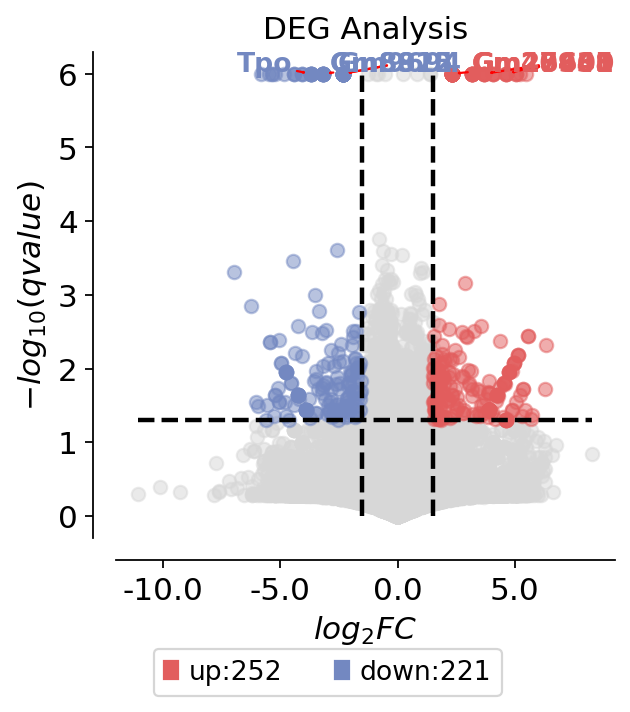

In [11]:
dds.plot_volcano(title='DEG Analysis',figsize=(4,4),
                 plot_genes_num=8,plot_genes_fontsize=12,)

为了可视化特定的基因，我们只需要使用dds.boxplot函数来完成绘图。

(<Figure size 160x240 with 1 Axes>,
 <AxesSubplot: title={'center': 'Gene Expression'}>)

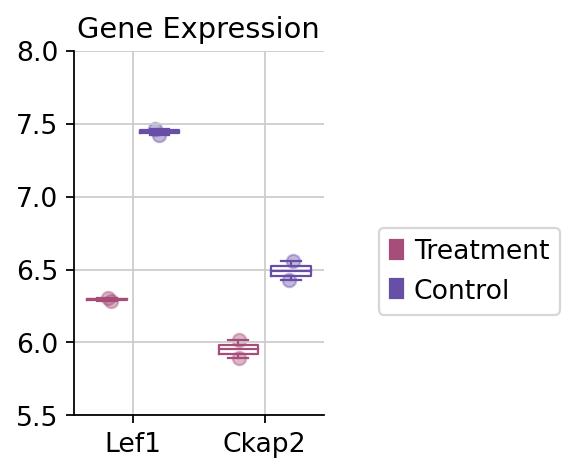

In [12]:
dds.plot_boxplot(genes=['Ckap2','Lef1'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))

(<Figure size 160x240 with 1 Axes>,
 <AxesSubplot: title={'center': 'Gene Expression'}>)

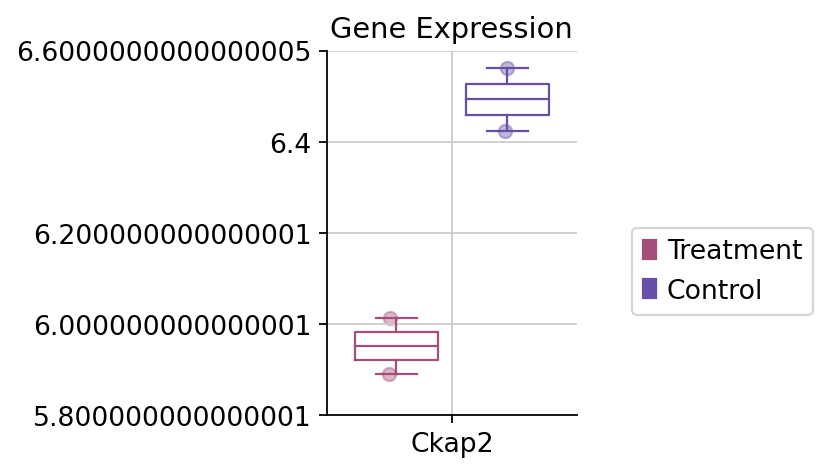

In [13]:
dds.plot_boxplot(genes=['Ckap2'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))

## 途径富集分析
在这里，我们使用GSAPY软件包，其中包括GSEA分析和富集。我们已经优化了软件包的输出，并给出了一些更好的图形绘图功能
同样，我们需要先下载途径/基因。我们以前准备的五个基因，您可以使用`ov.utils.download_pathway_database()`自动下载。此外，您可以下载您从[`Enrichr`](https://maayanlab.cloud/Enrichr/#libraries)感兴趣的`pathway`：



In [14]:
ov.utils.download_pathway_database()

......Pathway Geneset download start: GO_Biological_Process_2021
......Downloading dataset save to genesets/GO_Biological_Process_2021.txt
......Creating directory genesets
......[GO_Biological_Process_2021 Size of file]: 0.15 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！44.59714365005493.2f s
......Pathway Geneset download start: GO_Cellular_Component_2021
......Downloading dataset save to genesets/GO_Cellular_Component_2021.txt
......[GO_Cellular_Component_2021 Size of file]: 0.03 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！4.136761665344238.2f s
......Pathway Geneset download start: GO_Molecular_Function_2021
......Downloading dataset save to genesets/GO_Molecular_Function_2021.txt
......[GO_Molecular_Function_2021 Size of file]: 0.03 MB
......[Downloader]: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00%
.......Finish！8.36381721496582.2f s
......Pathway Geneset download sta

In [16]:
pathway_dict=ov.utils.geneset_prepare('../../data/genesets/WikiPathways_2019_Mouse.txt',
                                      organism='Mouse')
pathway_dict

{'ACE Inhibitor Pathway WP396': ['Ren2',
  'Ace',
  'Ren1',
  'Nos3',
  'Agtr2',
  'Bdkrb2',
  'Agtr1a',
  'Agt',
  'Kng1'],
 'Acetylcholine Synthesis WP175': ['Ache',
  'Pcyt1a',
  'Pdha2',
  'Pdha1',
  'Chka',
  'Chat',
  'Pemt'],
 'Adipogenesis genes WP447': ['Tgfb1',
  'Gh',
  'Tle3',
  'Prlr',
  'Wnt5b',
  'Ebf1',
  'Osm',
  'Lifr',
  'Agt',
  'Gdf10',
  'Sfrp4',
  'Fas',
  'Lep',
  'Il6st',
  'Agrp',
  'Cntfr',
  'Rb1',
  'Epas1',
  'Serpine1',
  'Ucp1',
  'Retn',
  'Ahr',
  'Tnf',
  'Cisd1',
  'Gm45929',
  'Foxo1',
  'Lmna',
  'Rxra',
  'Frzb',
  'E2f1',
  'Spock1',
  'Stat6',
  'E2f4',
  'Rxrg',
  'Ppargc1a',
  'Wwtr1',
  'Smad3',
  'Stat5b',
  'Srebf1',
  'Fzd1',
  'Egr2',
  'Wnt10b',
  'Gadd45b',
  'Gadd45a',
  'Mif',
  'Nr2f1',
  'Nsg1',
  'Igf1',
  'Klf15',
  'Creb1',
  'Hnf1a',
  'Ins1',
  'Ins2',
  'Cfd',
  'Irs1',
  'Irs2',
  'Lpl',
  'Irs3',
  'Slc2a4',
  'Twist1',
  'Irs4',
  'Gata4',
  'Gata3',
  'Hif1a',
  'Gata2',
  'Rora',
  'Lipe',
  'Ndn',
  'Stat5a',
  'Ncoa2',


请注意，我们将`pvalue_type`设置为`auto`，这是因为当我们富集的基因集太小时，使用调整后的`adjusted pvalue`我们无法得到正确的结果。因此，您可以设置`adjusted`或`raw`以获得重要的基因集。

In [17]:
deg_genes=dds.result.loc[dds.result['sig']!='normal'].index.tolist()
enr=ov.bulk.geneset_enrichment(gene_list=deg_genes,
                                pathways_dict=pathway_dict,
                                pvalue_type='auto',
                                organism='mouse')

为了可视化富集，我们使用`gene_plot`来完成它

<AxesSubplot: title={'center': 'Wiki Pathway enrichment'}, xlabel='Fractions of genes'>

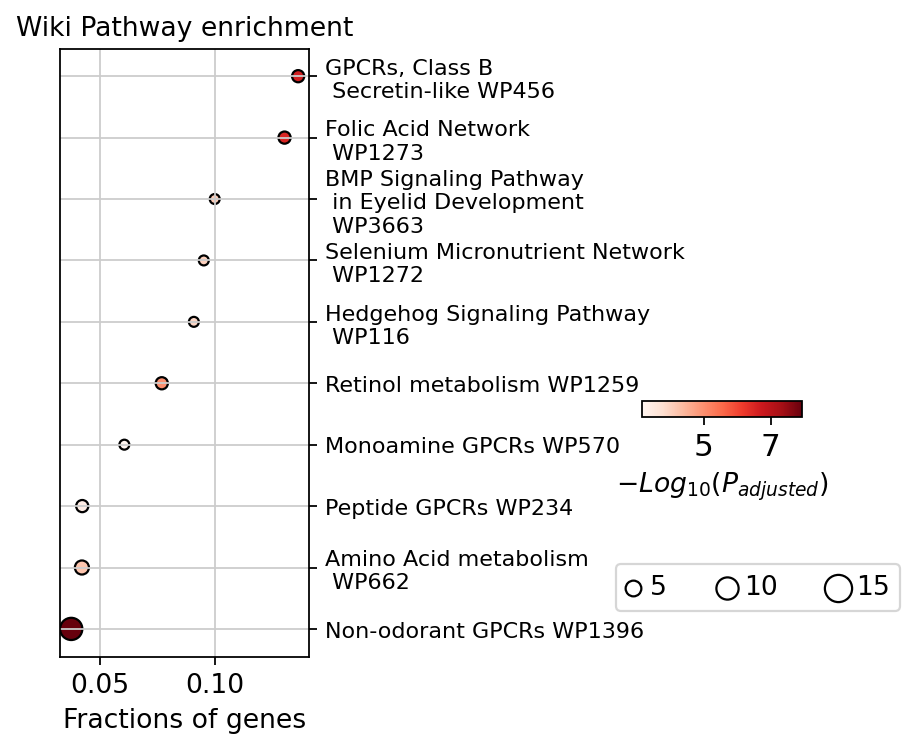

In [18]:
ov.bulk.geneset_plot(enr,figsize=(2,5),fig_title='Wiki Pathway enrichment',
                    cax_loc=[2, 0.45, 0.5, 0.02],
                    bbox_to_anchor_used=(-0.25, -13),node_diameter=10,
                     custom_ticks=[5,7],text_knock=3,
                    cmap='Reds')